From https://towardsdatascience.com/carryover-and-shape-effects-in-media-mix-modeling-paper-review-fd699b509e2d

In [1]:
import numpy as np
import pandas
import arviz as az
import pymc3 as pm
import plotly.express as px
import statsmodels

WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [2]:
def geoDecay(alpha, L):
    '''
    weighted average with geometric decay
    weight_T = alpha ^ T-1 
    returns: weights of length L to calculate weighted averages with. 
    '''
    return alpha**(np.ones(L).cumsum()-1)

def delayed_adstock(alpha, theta, L):
    '''
    weighted average with dealyed adstock function
    weight_T = 
    returns: weights of length L to calculate weighted averages with. 
    '''
    return alpha**((np.ones(L).cumsum()-1)-theta)**2

def carryover(x, alpha, L, theta = None, func='geo'):
    '''
    1. x is a vector of media spend going back L timeslots, so it should be len(x) == L
    2. Weights is a vector of length L showing how much previous time periods spend has on current period. 
    3. L is max length of Lag.
    returns transformed vector of spend
    # update with numpy average 
    # np.average(x[:2], weights=[1,.9])
    '''
    transformed_x = []
    if func=='geo':
        weights = geoDecay(alpha, L)
        
    elif func=='delayed':
        weights = delayed_adstock(alpha, theta, L)
    
    for t in range(x.shape[0]):
        upper_window = t+1
        lower_window = max(0,upper_window-L)
        current_window_x = x[:upper_window]
        t_in_window = len(current_window_x)
        if t < L:
            new_x = (current_window_x*np.flip(weights[:t_in_window], axis=0)).sum()
            transformed_x.append(new_x/weights[:t_in_window].sum())
        elif t >= L:
            current_window_x = x[upper_window-L:upper_window]
            ext_weights = np.flip(weights, axis=0) 
            new_x = (current_window_x*ext_weights).sum()
            transformed_x.append(new_x/ext_weights.sum())
            
    return np.array(transformed_x)

def beta_hill(x, S, K, beta):
    return beta - (K**S*beta)/(x**S+K**S)

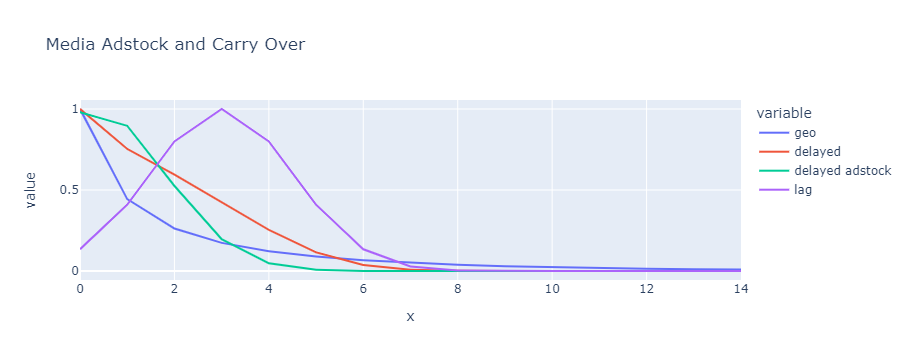

In [3]:
L = 15
x = range(L)
media = np.zeros(L)
media[0] = 1
media = np.array(media)
df = pandas.DataFrame()
df['x'] = x
df['geo'] = carryover(media, .8, L, 3, 'geo')
df['delayed'] = carryover(media, .8, L, 3, func='delayed')
df['delayed adstock'] = delayed_adstock(.8, .3, L)
df['lag'] = .8**((np.ones(L).cumsum()-1)-3)**2
fig = px.line(df, x="x", y=['geo', 'delayed', 'delayed adstock', 'lag'], 
              title='Media Adstock and Carry Over')
fig.show()

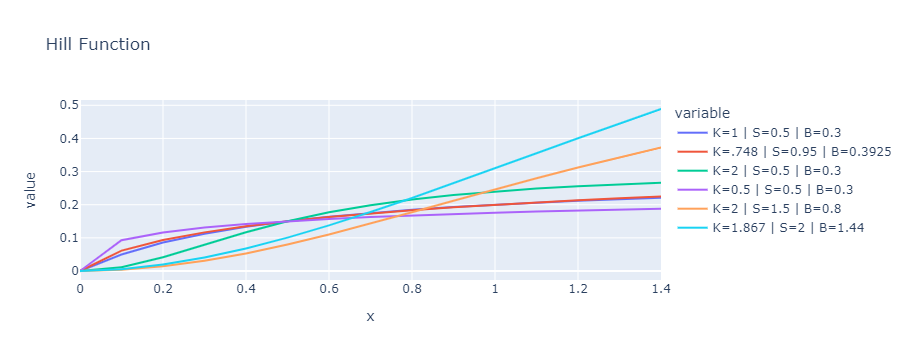

In [4]:
L = 15
x = [float(x)/10.0 for x in range(L)]
df = pandas.DataFrame()
df['x'] = x
df['K=1 | S=0.5 | B=0.3'] = [beta_hill(i, 1, 0.5, 0.3) for i in x]
df['K=.748 | S=0.95 | B=0.3925'] = [beta_hill(i, .748, .95, .3925) for i in x]
df['K=2 | S=0.5 | B=0.3'] = [beta_hill(i, 2, 0.5, 0.3) for i in x]
df['K=0.5 | S=0.5 | B=0.3'] = [beta_hill(i, 0.5, 0.5, 0.3) for i in x]
df['K=2 | S=1.5 | B=0.8'] = [beta_hill(i, 2, 1.5, 0.8) for i in x]
df['K=1.867 | S=2 | B=1.44'] = [beta_hill(i, 1.867, 2, 1.44) for i in x]
y =['K=1 | S=0.5 | B=0.3', 'K=.748 | S=0.95 | B=0.3925', 'K=2 | S=0.5 | B=0.3',
   'K=0.5 | S=0.5 | B=0.3', 'K=2 | S=1.5 | B=0.8', 'K=1.867 | S=2 | B=1.44']
fig = px.line(df, x="x", y=y, title='Hill Function')
fig.show()

In [5]:
# media channels 
N = 102 # number of data points
t = np.linspace(0, 4*np.pi, N)
data = 3+np.sin(t+0.001) + 0.5 + np.random.randn(N)
media_1 = ((data-min(data))/(max(data)-min(data)) ) 

t = np.linspace(0, 4*np.pi, N)
data = 3+np.sin(t+0.001) + 0.5 + np.random.randn(N)
media_2 = ((data-min(data))/(max(data)-min(data)) )  

t = np.linspace(0, 4*np.pi, N)
data = 3+np.sin(t+0.001) + 0.5 + np.random.randn(N)
media_3 = ((data-min(data))/(max(data)-min(data)) )  

# price 
from statsmodels.tsa import arima_process as arima

arparams = np.array([.7, .6])
maparams = np.array([.1, .02])
ar = np.r_[1, arparams] # add zero-lag and negate
ma = np.r_[1, maparams] 
price_variable = arima.arma_generate_sample(ar,ma,102)
alpha_media_1 = .6
theta_media_1 = 5
k_media_1     = .2
s_media_1     = 1
beta_media_1  = .8

alpha_media_2 = .8
theta_media_2 = 3
k_media_2     = .2
s_media_2     = 2
beta_media_2  = .6
 
alpha_media_3 = .8
theta_media_3 = 4
k_media_3     = .2
s_media_3     = 2
beta_media_3  = .3

L=13
ru=4
lamb = -.5
ep = .05**2

m1 = [beta_hill(x, s_media_1, k_media_1, beta_media_1) for x in carryover(media_1, alpha_media_1, L, theta = theta_media_1, func='delayed')]
m2 = [beta_hill(x, s_media_2, k_media_2, beta_media_2) for x in carryover(media_2, alpha_media_2, L, theta = theta_media_2, func='delayed')]
m3 = [beta_hill(x, s_media_3, k_media_3, beta_media_3) for x in carryover(media_3, alpha_media_3, L, theta = theta_media_3, func='delayed')]
 
y = np.repeat(ru, N) + m1 + m2 + m3 + (lamb*price_variable) + np.random.normal(0, ep, N)

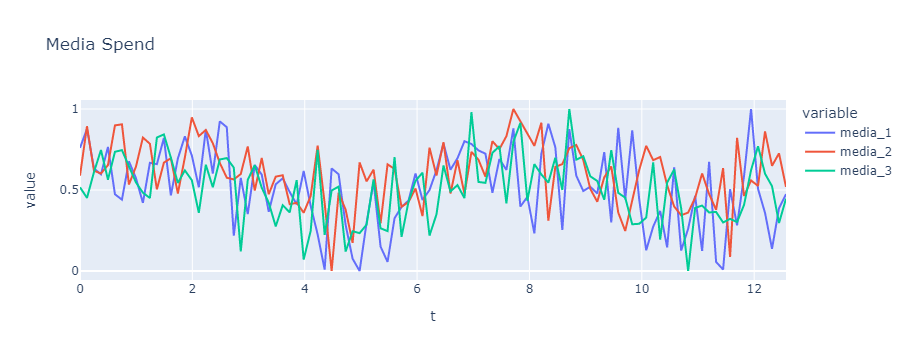

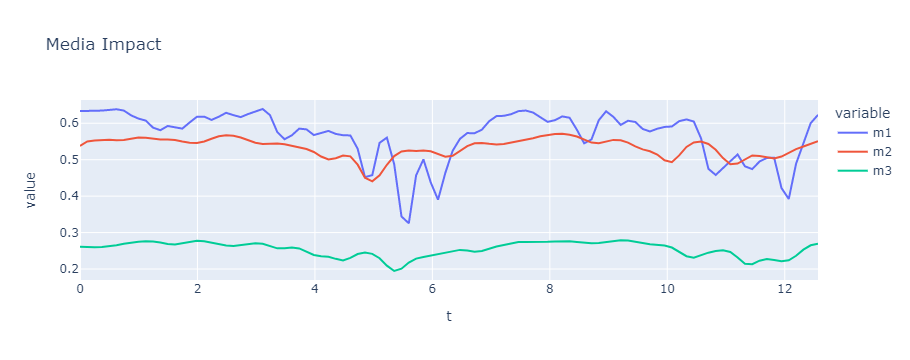

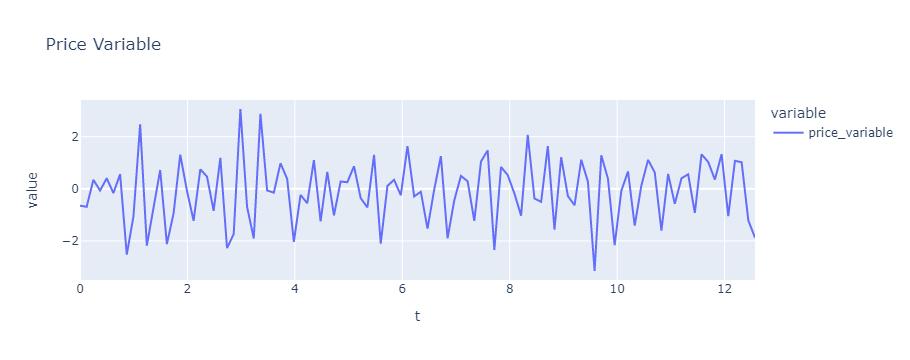

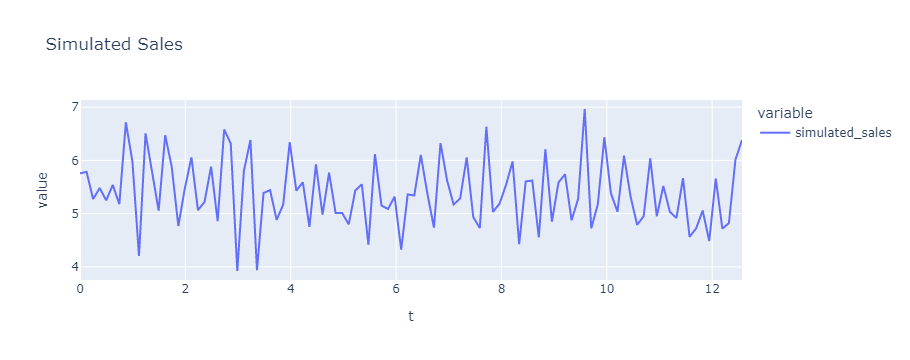

In [6]:
df = pandas.DataFrame()
df['t'] = t
df['media_1'] = media_1
df['media_2'] = media_2
df['media_3'] = media_3
df['m1'] = m1
df['m2'] = m2
df['m3'] = m3
df['price_variable'] = price_variable
df['simulated_sales'] = y
fig = px.line(df, x="t", y=['media_1', 'media_2', 'media_3'], title='Media Spend')
fig.show()
fig = px.line(df, x="t", y=['m1', 'm2', 'm3'], title='Media Impact')
fig.show()
fig = px.line(df, x="t", y=['price_variable'], title='Price Variable')
fig.show()
fig = px.line(df, x="t", y=['simulated_sales'], title='Simulated Sales')
fig.show()

In [ ]:
with pm.Model() as m:
    alpha = pm.Beta('alpha'          , 3 , 3  , shape=3)
    theta = pm.Uniform('theta'       , 0 , 12 , shape=3)
    k     = pm.Beta('k'              , 2 , 2  , shape=3)
    s     = pm.Gamma('s'             , 3 , 1 , shape=3)
    beta  = pm.HalfNormal('beta'     , 1      , shape=3)
    ru    = pm.HalfNormal('intercept', 5) 
    lamb  = pm.Normal('lamb'         , 0 , 1) 
    noise = pm.InverseGamma('noise'  , 0.05, 0.0005) 
    
    transpose_m1 = [beta_hill(x, s[0], k[0], beta[0]) for x in carryover(media_1, alpha[0], L, theta = theta[0], func='delayed')]
    transpose_m2 = [beta_hill(x, s[1], k[1], beta[1]) for x in carryover(media_2, alpha[1], L, theta = theta[1], func='delayed')]
    transpose_m3 = [beta_hill(x, s[2], k[2], beta[2]) for x in carryover(media_3, alpha[2], L, theta = theta[2], func='delayed')]
    
    y_hat = pm.Normal('y_hat', mu=ru + transpose_m1 + transpose_m2 + transpose_m3 + lamb * price_variable,
                  sigma=noise, 
                  observed=y)
    trace = pm.fit(method='svgd')

In [8]:
with m:
    # instantiate sampler
    step = pm.Slice()
    # draw 5000 posterior samples
    trace = pm.sample(1000, step=step, return_inferencedata=False)

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Slice: [noise]
>Slice: [lamb]
>Slice: [intercept]
>Slice: [beta]
>Slice: [s]
>Slice: [k]
>Slice: [theta]
>Slice: [alpha]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 504 seconds.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


/usr/local/lib/python3.9/site-packages/arviz/stats/density_utils.py:248: RuntimeWarning:

divide by zero encountered in double_scalars

/usr/local/lib/python3.9/site-packages/arviz/stats/density_utils.py:252: RuntimeWarning:

divide by zero encountered in double_scalars

/usr/local/lib/python3.9/site-packages/arviz/stats/density_utils.py:276: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.9/site-packages/arviz/stats/density_utils.py:760: RuntimeWarning:

invalid value encountered in true_divide

/usr/local/lib/python3.9/site-packages/arviz/stats/density_utils.py:770: UserWarning:

Something failed when estimating the bandwidth. Please check your data

/usr/local/lib/python3.9/site-packages/arviz/stats/density_utils.py:248: RuntimeWarning:

divide by zero encountered in double_scalars

/usr/local/lib/python3.9/site-packages/arviz/stats/density_utils.py:252: RuntimeWarning:

divide by zero encountered in double_scalars

/usr/local/lib/python3.9/site-

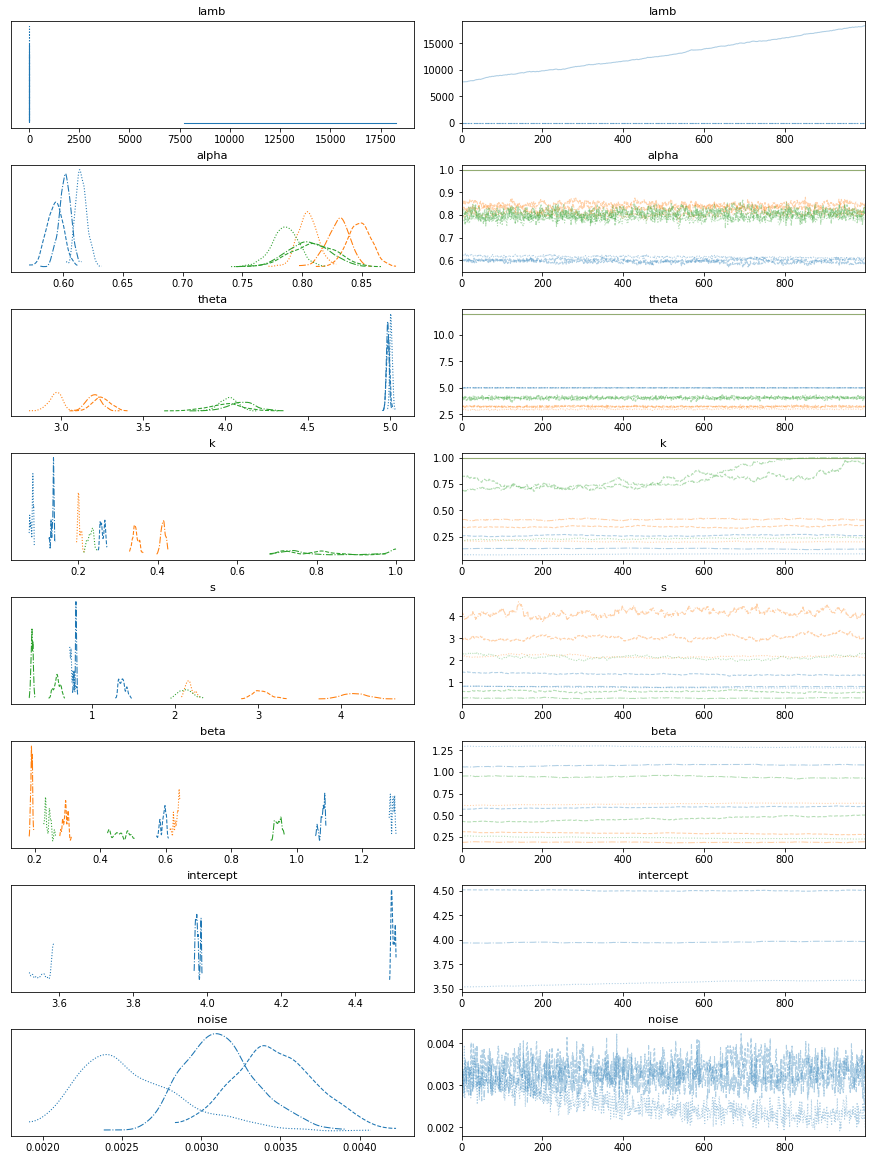

In [10]:
with m:
    az.plot_trace(trace);